In [1]:
#import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

import statistics
from scipy.stats import norm
from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import GridSearchCV
import datetime
from math import sqrt
from keras import regularizers
import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN
from tensorflow.keras.optimizers import SGD, Adadelta, Adam, RMSprop, Adagrad, Nadam, Adamax

In [2]:
#import data
data = pd.read_csv("../MODELING TOKEN BUCKET USING LSTM model/H264-data/silence_of_the_lamb_G16B7_QP10.csv",infer_datetime_format=True,
                  parse_dates=['arrival_time'], index_col='arrival_time', 
                   names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [3]:
data.head()

,decoded_frame,video_frame,frame_size,x,y,z
arrival_time,,,,,,
0.00000,0,I,536,98.19,92.17,92.17
266.66667,8,P,152,98.19,92.17,92.17
33.33333,1,B,136,98.19,92.17,92.17
66.66667,2,B,136,98.19,92.17,92.17
100.00000,3,B,136,98.19,92.17,92.17


In [4]:
data.dropna(0,inplace= True)

In [5]:
#drop decoded frame column
data.drop(('decoded_frame'), axis=1, inplace=True)

data.drop(('x'), axis=1, inplace=True)
data.drop(('y'), axis=1, inplace=True)
data.drop(('z'), axis=1, inplace=True)

In [6]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data['video_frame'])
print(list(le.classes_))
data['video_frame'] = le.transform(data['video_frame'])

['B', 'I', 'P']


In [7]:
data.head(5)

,video_frame,frame_size
arrival_time,,
0.00000,1,536
266.66667,2,152
33.33333,0,136
66.66667,0,136
100.00000,0,136


In [8]:
# data labels
labels_index = { "B" : 0, "I" : 1, "P" : 2} 

In [9]:
indexNames1 = data[data['video_frame'] == 0 ].index

# Delete these row indexes from dataFrame
data.drop(indexNames1 , inplace=True)

In [10]:
data.head()

,video_frame,frame_size
arrival_time,,
0.00000,1,536
266.66667,2,152
533.33333,1,528
800.00000,2,160
1066.66667,1,528


In [11]:
data.frame_size.dropna(0, inplace=True)

In [12]:
dataset = data.frame_size.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset.shape

(6750,)

In [13]:
dataset = pd.DataFrame(dataset)
print(dataset.shape)

(6750, 1)


In [14]:
# *****************split into train and test sets********************

test_split = int(len(dataset) * 0.8)

train = dataset[:test_split]
test = dataset[test_split:]

In [15]:
#********Data normalization**************************

scaler = MinMaxScaler(feature_range=(-1, 1))

train = scaler.fit_transform(train)
test = scaler.transform(test)

In [16]:
look_back= 3
def create_dataset(data, look_back):
    
    dataX, dataY = [], []
    for i in range(0,len(data) - look_back -1):
        a = data[i:(i+look_back),0]
        dataX.append(a)
        b= (data[i + look_back,0])
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [17]:
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5396, 3) (5396,)
(1346, 3) (1346,)


In [18]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train',X_train.shape)
print('X_test', X_test.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

X_train (5396, 3, 1)
X_test (1346, 3, 1)


In [19]:
#********************Build Model****************************

def lstm_model():
    
    model = tf.keras.models.Sequential()
    model.add(LSTM(128, input_shape=(look_back,1),kernel_regularizer=regularizers.l2(0.001),
              return_sequences=True ))
    #model.add(tf.keras.layers.Dropout(rate=0.20))
    model.add(LSTM(64, kernel_regularizer=regularizers.l2(0.001)))
    #model.add(tf.keras.layers.Dropout(rate=0.20))
    #model.add(LSTM(128, kernel_initializer='glorot_uniform',activation='relu'))
    model.add(Dense(1))
    model.summary()
    
     #optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer= 'adam', loss='mse')
      
    return model

In [20]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]

lstm_model = lstm_model()


history_lstm_model = lstm_model.fit(X_train, y_train, batch_size = 32,validation_split=0.2,
                                                      epochs =300, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
135/135 [==============================] - 6s 21ms/step - loss: 0.2165 - val_loss: 0.0520
Epoch 2/300
135/135 [==============================] - 1s 4ms/step - loss: 0.0959 - val_loss: 0.0398
Epoch 3/300
135/135 [==============================] - 1s 4ms/step - loss: 0.0828 - val_loss: 0.0375
Epoch 4/300
135/135 [==============================] - 1s 4ms/step - loss: 0

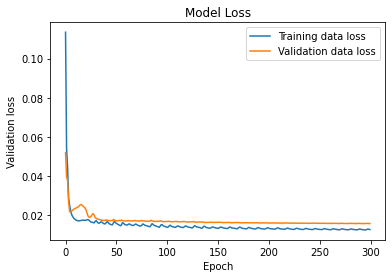

In [21]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history_lstm_model.history['loss'])
plt.plot(history_lstm_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

In [22]:
# convert 1 D to 2D array
y_train = y_train.reshape((y_train.shape[0], 1))
#print(test_y.shape)

# convert 1 D to 2D array
y_test = y_test.reshape((y_test.shape[0], 1))
#print(test_y.shape)

In [23]:
# Prediction Time !!!!

yhat_lstm_model = lstm_model.predict(X_test)

#mse_lstm_single_step = mean_squared_error(y_test, yhat_lstm_single_step)
#rmse_lstm = sqrt(mse_lstm_single_step)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#models.loc['rmse','LSTM_many_to_one'] = np.sqrt(mean_squared_error(y_test, yhat_lstm_single_step))
#models.loc['MAPE','LSTM_many_to_one'] = mean_absolute_percentage_error(y_test, yhat_lstm_single_step)
#models.loc['MAE','LSTM_many_to_one'] = mean_absolute_error(y_test, yhat_lstm_single_step)*100

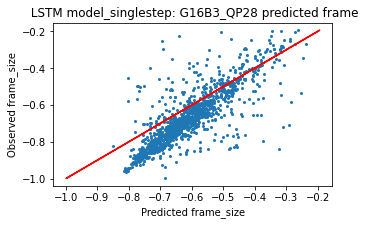

In [24]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(lstm_model.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title(' LSTM model_singlestep: G16B3_QP28 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

In [25]:
n_pred=10
ind_pred = lstm_model.predict(X_test[:n_pred])
print('Real frame size, Predicted frame size:')
for i, pred in enumerate(ind_pred):
    print((y_test[i]), (pred), sep=', ')

Real frame size, Predicted frame size:
[-0.71622349], [-0.639314]
[-0.39993541], [-0.39946258]
[-0.69529073], [-0.651281]
[-0.40814105], [-0.39021856]
[-0.67347281], [-0.6381439]
[-0.39761486], [-0.40116107]
[-0.68409469], [-0.6227952]
[-0.4039545], [-0.3996982]
[-0.66734848], [-0.63046455]
[-0.52232629], [-0.4003623]


In [26]:
# *************************invert predictions**************************

lstm_model_inv = scaler.inverse_transform(yhat_lstm_model)
test_y_inv = scaler.inverse_transform(y_test)

In [27]:
n_pred=10
print('Real frame size, Predicted frame size:')
for i, pred in enumerate(lstm_model_inv[:n_pred]):
    print((test_y_inv[i]), (pred), sep=', ')

Real frame size, Predicted frame size:
[95048.], [120766.84]
[200816.], [200974.11]
[102048.], [116765.03]
[198072.], [204065.36]
[109344.], [121158.13]
[201592.], [200406.14]
[105792.], [126290.79]
[199472.], [200895.33]
[111392.], [123726.13]
[159888.], [200673.25]


# Save the predicted csv file

In [28]:
#Save the predicted frame_size as .csv file
lstm_df = pd.DataFrame(lstm_model_inv)
lstm_df.to_csv('LSTM predicted frame_size_silence_of_the_lamb_G16B7_QP10.csv', index= None)

In [29]:
#import data
lstm_df = pd.read_csv("LSTM predicted frame_size_silence_of_the_lamb_G16B7_QP10.csv", names=['frame_size'])

In [30]:
lstm_df.head()

,frame_size
0,0.00
1,120766.84
2,200974.11
3,116765.03
4,204065.36


In [31]:
lstm_df.frame_size.dropna(0,inplace= True)

In [32]:
lstm_df.shape

(1347, 1)

In [33]:
mean_df = np.mean(lstm_df.frame_size)
print(mean_df)
peak_frame_lstm = np.max(lstm_df.frame_size)
print(peak_frame_lstm)
total_lstm = np.sum(lstm_df.frame_size)
print(total_lstm)

127772.66804305866
255754.16
172109783.854


In [34]:
lstm_df.shape[0]

1347

In [35]:


for m in range(20):
    byte_sent = 0
    deleted_bytes = 0
    bucket_size = 0
    marked_bytes = 0
    j = 0
    l = 0
    max_bucket_size = m * peak_frame_lstm
    
    for i in range(lstm_df.shape[0]):
        #print(i)
        bucket_size += mean_df
        if bucket_size > max_bucket_size:
            bucket_size = max_bucket_size
            l += 1
        
        if lstm_df.loc[i, 'frame_size'] <= bucket_size:
            byte_sent += lstm_df.loc[i, 'frame_size']
            bucket_size = (bucket_size - lstm_df.loc[i, 'frame_size'])
            
        else:
            byte_sent += bucket_size
            marked_bytes += (lstm_df.loc[i, 'frame_size'] - bucket_size)
            bucket_size = 0
            
    percent = marked_bytes * 100 / total_lstm
    print(percent)

100.00000000000001
8.709838288444455
7.782750694791201
7.275623350252482
6.978424487674219
6.779413251577196
6.630813820288066
6.482214388998934
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
6.408128695230678
